Utility plotting functions and node labels

In [1]:
import sys
sys.path.append('..')
from typing import Optional
import numpy as np
import torch as tc
import matplotlib.pyplot as plt
from scipy import stats
from plotting.plot_circular_graph import plot_circular_graph
import eval_reallabor_utils

def plot_network_graph(networks: tc.Tensor, directed: bool=True, alpha_level: float=0.01, fisher_transform: bool=False, edge_threshold: Optional[float]=None,
                       node_labels: Optional[list]=None, title: Optional[str]=None, ax: Optional[plt.Axes]=None):    

    if fisher_transform:
        networks = tc.arctanh(networks)
    sig_adj = stats.ttest_1samp(networks, 0, axis=0).pvalue   # Show only connections with a weight significantly different from 0
    networks = tc.nanmean(networks, dim=0)
    if fisher_transform:
        networks = tc.tanh(networks)
    for i in range(networks.shape[0]):
        networks[i,i] = 0       # Do not show auto-connections
    networks_pos = networks * (networks > 0) * (sig_adj < alpha_level)
    networks_neg = networks * (networks < 0) * (sig_adj < alpha_level)

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6.27, 6.27))
    ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)
    plot_circular_graph(networks_pos, directed=directed, labels=node_labels, ax=ax,
                            edge_kwargs={'edge_color':'k'})
    plot_circular_graph(-networks_neg, directed=directed, labels=node_labels, ax=ax,
                            edge_kwargs={'edge_color':'red'})
    ax.set(xlim=(-2,2), ylim=(-2,2))
    if title is not None:
        ax.set_title(title)
    plt.tight_layout()
    return ax, sig_adj


def plot_out_degree_centrality(networks: tc.Tensor, significant_only: bool=True, alpha_level: float=0.05,
                               node_labels: Optional[list]=None, ax: Optional[plt.Axes]=None):

    if significant_only:
        sig_adj = stats.ttest_1samp(networks, 0, axis=0).pvalue
        networks = networks * (sig_adj < alpha_level)
    out_degree_centrality = eval_reallabor_utils.weighted_degree_centrality(networks, mode='out', absolute=True)
    mean_centrality = tc.nanmean(out_degree_centrality, dim=0)
    sem_centrality = tc.nanmean((out_degree_centrality - mean_centrality)**2, dim=0) / np.sqrt(out_degree_centrality.shape[0])
    order = tc.argsort(mean_centrality, descending=True)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6.27, 2.5))
    ax.bar(range(len(mean_centrality)), mean_centrality[order], yerr=sem_centrality[order])
    if node_labels is not None:
        node_labels = np.array(node_labels)
        ax.set_xticks(range(len(mean_centrality)), labels=node_labels[order], rotation=45, ha='right')
    return ax

import data_utils
sys.path.append(data_utils.join_base_path('reallaborai4u/preprocessing'))
from feature_names import NON_CONDITIONAL_FEAT as LABELS

# import os
# os.makedirs('../results/_paper/network_perturbation_analyses/networks', exist_ok=True)

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


PLRNN networks: cluster participants according to networks

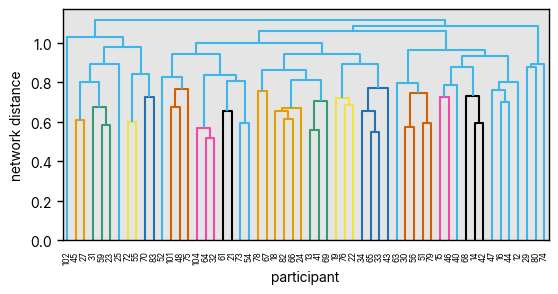

In [5]:
import sys
sys.path.append('..')
import torch as tc
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from bptt.plrnn import PLRNN

MRT = [2]
combined_eval_file = []

with PaperStyle(settings={'axes.grid':False}):

    for mrt in MRT:

        results_dir = data_utils.join_ordinal_bptt_path('results', f'v2_MRT{mrt}_every_day_x6')
        test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')

        models = eval_reallabor_utils.ModelCatalogue(results_dir)
        data_files = data_utils.get_data_files(test_data_dir)
        participants = data_utils.get_participant_ids(data_files)

        pid = data_utils.get_participant_ids(data_files)
        networks = []
        for p, df in data_utils.zip_participants_data(test_data_dir):
            model_dirs = models.get_latest_model_dirs(p, timestep=1000)
            if model_dirs is None:
                continue
            latest_models_network = []
            for model_dir in model_dirs:
                args = utils.load_args(model_dir)
                model = PLRNN()
                model.init_from_model_path(model_dir)
                x = tc.tensor(df[LABELS].to_numpy()).float()
                network = eval_reallabor_utils.get_network_matrix(model, x).nanmean(0)
                latest_models_network.append(network.flatten().numpy())
            latest_models_network = np.mean(latest_models_network, axis=0)
            networks.append(latest_models_network)
        networks = np.stack(networks, axis=0)
        Z = linkage(networks, method='complete', metric='cosine', optimal_ordering=True)

        fig, ax = plt.subplots(figsize=(6.27, 3))
        dn = dendrogram(Z, ax=ax, labels=pid, leaf_rotation=90)
        ax.set(ylabel=f'network distance', xlabel='participant')

        # cluster_index = pd.Series(dn['leaves_color_list'], index=dn['ivl'])

        
        

    plt.show()

PLRNN Jacobians

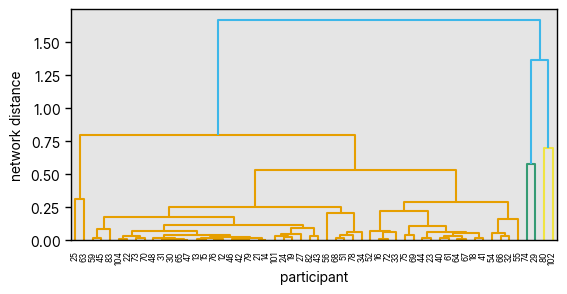

In [6]:
import sys
sys.path.append('..')
import torch as tc
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from bptt.plrnn import PLRNN

MRT = [2]
combined_eval_file = []

with PaperStyle(settings={'axes.grid':False}):

    for mrt in MRT:

        results_dir = data_utils.join_ordinal_bptt_path('results', f'v2_MRT{mrt}_every_day_x6')
        test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')

        models = eval_reallabor_utils.ModelCatalogue(results_dir)
        data_files = data_utils.get_data_files(test_data_dir)
        participants = data_utils.get_participant_ids(data_files)
        networks = []
        for p, df in data_utils.zip_participants_data(test_data_dir):
            model_dirs = models.get_latest_model_dirs(p, timestep=1000)
            if model_dirs is None:
                continue
            latest_models_network = []
            for model_dir in model_dirs:
                args = utils.load_args(model_dir)
                model = PLRNN()
                model.init_from_model_path(model_dir)
                x = tc.tensor(df[LABELS].to_numpy()).float()
                if model.args['mean_centering']:
                    x = x - model.data_mean
                B_inv = tc.pinverse(model.get_parameters()['B'])
                network = model.jacobian(tc.einsum('lo,bo->bl', B_inv, x)).nanmean(0)
                latest_models_network.append(network.flatten().numpy())
            latest_models_network = np.mean(latest_models_network, axis=0)
            networks.append(latest_models_network)
        networks = np.stack(networks, axis=0)
        Z = linkage(networks, method='complete', metric='cosine', optimal_ordering=True)

        fig, ax = plt.subplots(figsize=(6.27, 3))
        dn = dendrogram(Z, ax=ax, labels=participants, leaf_rotation=90)
        ax.set(ylabel=f'network distance', xlabel='participant')

    plt.show()